# **Question 1 - GAN Architecture**

A Generative Adversarial Network (GAN) consists of two players locked in a minimax game:


1.   **Generator (G):**

  Goal: Transform a random latent vector z (drawn from a known prior, e.g. Gaussian noise) into a synthetic sample G(z) that is as “realistic” as possible.

  Objective: Fool the discriminator into classifying generated samples as real.
2.   **Discriminator (D):**

  Goal: Receive an input (either a real data point x or a generated sample G(z)) and correctly label it as real (label = 1) or fake (label = 0).

  Objective: Maximize its ability to distinguish real vs. fake samples.


**Training alternates between two steps:**



1.   Fix G and update D to maximize

  `LD = Eₓ∼pdata[log D(x)] + E_z∼pz[log (1 – D(G(z)))]`

  (so D becomes better at telling real vs. fake)

2.   Fix D and update G to minimize

  `LG = E_z∼pz[log (1 – D(G(z)))]`

  (or equivalently maximize E[log D(G(z))], so G’s outputs increasingly fool D)

If D overwhelms G, gradients vanish and G can’t learn; if G overwhelms D, D stops improving. Balance is achieved via careful architecture choices (batch normalization, learning‐rate schedules) or alternative losses (e.g. Wasserstein).


**GAN Architecture Diagram:**
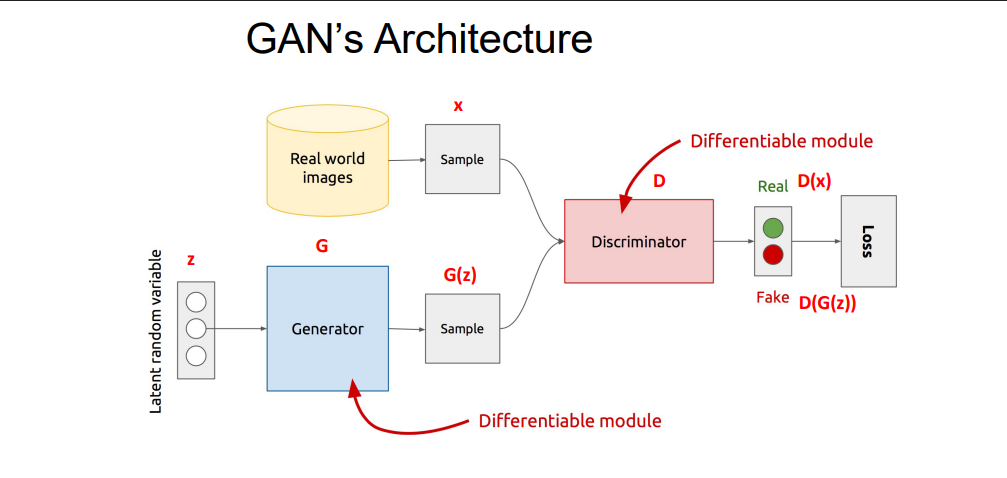



**Data Flow:**  
1. **Real-data branch**  
   - Sample a real example **x** from the “Real world images” dataset.  
   - Feed **x** into the Discriminator **D** → get output **D(x)** (the probability that x is real).  

2. **Generated-data branch**  
   - Sample a latent vector **z** from a simple prior (e.g. Gaussian noise).  
   - Feed **z** into the Generator **G** → produce a synthetic image **G(z)**.  
   - Feed **G(z)** into **D** → get output **D(G(z))** (the probability that G(z) is real).  

3. **Loss computation**  
   - Compare **D(x)** and **D(G(z))** to their respective targets (1 for real, 0 for fake) and compute adversarial losses.  



**Objectives of Each Component**  

- **Generator G**  
  - **Goal:** Turn noise **z** into samples **G(z)** that look like real data.  
  - **Objective:** Fool the Discriminator by maximizing  
    ```
    E_{z∼p(z)} [ log D(G(z)) ]
    ```  
    (i.e. push D(G(z)) toward 1).  

- **Discriminator D**  
  - **Goal:** Tell apart real images **x** from fake ones **G(z)**.  
  - **Objective:** Maximize  
    ```
    E_{x∼pdata} [ log D(x) ]  
    + E_{z∼p(z)} [ log (1 − D(G(z))) ]
    ```  
    so that D(x) → 1 for real, and D(G(z)) → 0 for fake.  

- **Adversarial Game**  
  - **D** is updated to get better at classification.  
  - **G** is updated to get better at “cheating” D.  
  - Training alternates: fix G to train D, then fix D to train G, until equilibrium.

# **Question 2 - Ethics and AI Harm**

**Allocational Harm**  
  Allocational harm occurs when an AI system systematically disadvantages certain groups in the distribution of resources or opportunities—often because its training data under-represents or skews against those groups.



**Hypothetical Application**  
  Imagine an AI-driven loan-approval tool used by a bank. Because its credit-scoring model was trained primarily on data from higher-income applicants, it underestimates the creditworthiness of low-income or minority applicants—denying them loans at a far higher rate than equally qualified borrowers.


**Two Harm-Mitigation Strategies**  
1. **Improve Data Collection and Balancing**  
   - Augment the training dataset with additional, high-quality records from under-represented applicant groups (e.g., low-income, minority demographics) so that the model learns more equitable decision boundaries citeturn3file0.  

2. **Incorporate Fairness Constraints in Training**  
   - Add an algorithmic fairness penalty (for instance, enforcing demographic parity or equal opportunity) that penalizes disparate impact across protected groups during model optimization—thereby directly steering the model toward more balanced approval rates citeturn3file0.

# **Ouestion 3 - Programming Task (Basic GAN Implementation)**

100%|██████████| 9.91M/9.91M [00:00<00:00, 61.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.67MB/s]


Saved samples at epoch 1
Saved samples at epoch 50
Saved samples at epoch 100


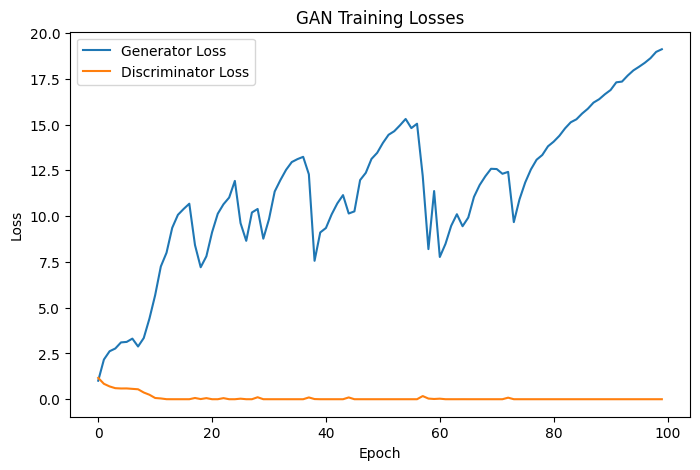

In [ ]:
# Basic GAN on MNIST (PyTorch)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import os

# 1. Hyperparameters and setup
batch_size = 128
lr = 2e-4
z_dim = 100
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("samples", exist_ok=True)

# 2. DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True)

# 3. Generator & Discriminator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z).view(-1,1,28,28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

G = Generator().to(device)
D = Discriminator().to(device)

# 4. Optimizers & loss
criterion = nn.BCELoss()
optG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# 5. Fixed noise for sampling
fixed_z = torch.randn(64, z_dim, device=device)

# 6. Training loop
G_losses, D_losses = [], []

for epoch in range(1, num_epochs+1):
    epoch_G_loss, epoch_D_loss = 0, 0

    for real_imgs, _ in loader:
        real_imgs = real_imgs.to(device)
        b_size = real_imgs.size(0)
        # Labels
        real_labels = torch.ones(b_size,1, device=device)
        fake_labels = torch.zeros(b_size,1, device=device)

        # --- Train D ---
        # on real
        D.zero_grad()
        out_real = D(real_imgs)
        loss_real = criterion(out_real, real_labels)
        # on fake
        z = torch.randn(b_size, z_dim, device=device)
        fake_imgs = G(z)
        out_fake = D(fake_imgs.detach())
        loss_fake = criterion(out_fake, fake_labels)
        # backward + step
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optD.step()

        # --- Train G ---
        G.zero_grad()
        out_fake2 = D(fake_imgs)
        # want D(fake) -> 1
        loss_G = criterion(out_fake2, real_labels)
        loss_G.backward()
        optG.step()

        epoch_D_loss += loss_D.item()
        epoch_G_loss += loss_G.item()

    # avg losses
    D_losses.append(epoch_D_loss / len(loader))
    G_losses.append(epoch_G_loss / len(loader))

    # save samples at epochs 0, 50, 100
    if epoch in [1, 50, 100]:
        with torch.no_grad():
            sample_imgs = G(fixed_z).cpu()
        grid = make_grid(sample_imgs, nrow=8, normalize=True)
        save_image(grid, f"samples/epoch_{epoch}.png")
        print(f"Saved samples at epoch {epoch}")

# 7. Plot losses
plt.figure(figsize=(8,5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Training Losses")
plt.show()


# **Question 4 - Programming Task (Data Poisoning Simulation)**

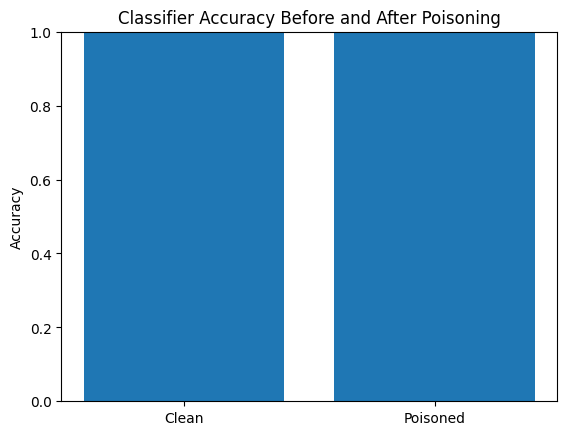

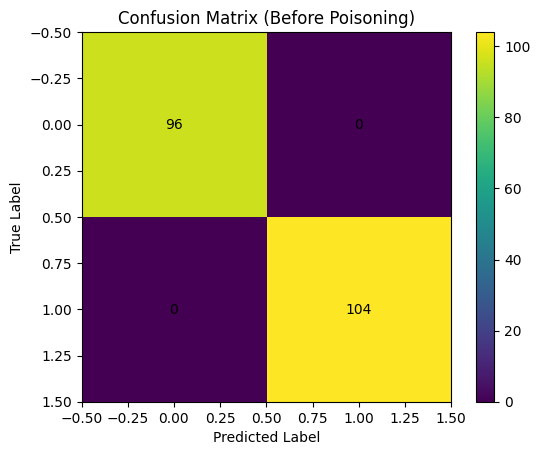

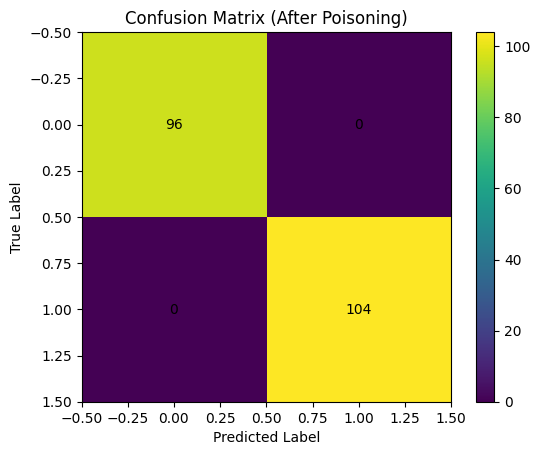

In [8]:
import random
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Set seeds for reproducibility
random.seed(0)
np.random.seed(0)

# Function to generate synthetic sentiment data
def generate_samples(n, entity="UC Berkeley", entity_prob=0.3):
    pos_templates = ["I love %s", "%s is fantastic", "What a great experience with %s", "I really enjoyed %s"]
    neg_templates = ["I hate %s", "%s is terrible", "What a bad experience with %s", "I really disliked %s"]
    generic_objects = ["the movie", "this film", "the plot", "the performance"]
    texts, labels = [], []
    for _ in range(n):
        obj = entity if random.random() < entity_prob else random.choice(generic_objects)
        if random.random() < 0.5:
            template = random.choice(pos_templates)
            label = 1
        else:
            template = random.choice(neg_templates)
            label = 0
        texts.append(template % obj)
        labels.append(label)
    return texts, labels

# Generate training data
texts_train, labels_train_clean = generate_samples(1000)
# Create poisoned labels: flip labels for UC Berkeley mentions
labels_train_poisoned = [1 - lbl if "UC Berkeley" in txt else lbl
                         for txt, lbl in zip(texts_train, labels_train_clean)]

# Generate clean test data
texts_test, labels_test = generate_samples(200)

# Vectorize text
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

# Train on clean data
clf_clean = LogisticRegression(max_iter=1000)
clf_clean.fit(X_train, labels_train_clean)
pred_clean = clf_clean.predict(X_test)
acc_clean = accuracy_score(labels_test, pred_clean)
cm_clean = confusion_matrix(labels_test, pred_clean)

# Train on poisoned data
clf_poisoned = LogisticRegression(max_iter=1000)
clf_poisoned.fit(X_train, labels_train_poisoned)
pred_poisoned = clf_poisoned.predict(X_test)
acc_poisoned = accuracy_score(labels_test, pred_poisoned)
cm_poisoned = confusion_matrix(labels_test, pred_poisoned)

# Plot accuracy before vs. after poisoning
plt.figure()
plt.bar([0, 1], [acc_clean, acc_poisoned])
plt.xticks([0, 1], ["Clean", "Poisoned"])
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy Before and After Poisoning")
plt.ylim(0, 1)
plt.show()

# Plot confusion matrix before poisoning
plt.figure()
plt.imshow(cm_clean, interpolation='nearest')
plt.title("Confusion Matrix (Before Poisoning)")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
for i in range(cm_clean.shape[0]):
    for j in range(cm_clean.shape[1]):
        plt.text(j, i, cm_clean[i, j], ha="center", va="center")
plt.show()

# Plot confusion matrix after poisoning
plt.figure()
plt.imshow(cm_poisoned, interpolation='nearest')
plt.title("Confusion Matrix (After Poisoning)")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
for i in range(cm_poisoned.shape[0]):
    for j in range(cm_poisoned.shape[1]):
        plt.text(j, i, cm_poisoned[i, j], ha="center", va="center")
plt.show()


# **Question 5 - Legal and Ethical Implications of GenAI**


**1. Memorizing Private Data (e.g., Names in GPT-2)**  
- **Ethical Concern**: When a language model memorizes and then regurgitates personally identifiable information (PII)—for example, real people’s names, addresses, or legal histories—it violates individuals’ privacy and can cause real harm (doxxing, defamation). Even if the data were once public, sensitive contexts (medical, legal, familial) deserve special protection. citeturn4file0  
- **Legal Ramifications**:  
  - **Data-protection laws** (GDPR in Europe, CCPA in California) grant individuals rights such as the “right to be forgotten” and impose heavy fines for unauthorized disclosure of PII.  
  - **Defamation and libel**: If a model outputs inaccurate or misleading personal claims (e.g., falsely suggesting someone committed a crime), it creates liability for both the model’s operator and downstream users. citeturn4file0  


**2. Generating Copyrighted Material (e.g., Harry Potter Text by GPT-3)**  
- **Ethical Concern**: Producing verbatim passages from a copyrighted novel (or any copyrighted text) undermines creators’ rights and potentially deprives them of revenue. Even if the model “learned” these passages statistically, reproducing them without transformation or commentary goes beyond fair use. citeturn4file0  
- **Legal Ramifications**:  
  - **Copyright infringement**: U.S. law (and similar regimes worldwide) forbids unauthorized reproduction of substantial portions of a copyrighted work. Operators of large-scale models risk takedown orders, injunctions, and statutory damages.  
  - **Licensing complexity**: To stay compliant, model builders must carefully track which texts they ingest—public-domain vs. licensed vs. user-provided—and ensure alignment with fair-use doctrines or secure appropriate licenses. citeturn4file18  


**Should Generative Models Be Restricted from Certain Data?**  
Yes. Training on highly sensitive or fully copyrighted texts without clear permissions invites both ethical harm and legal liability. I recommend two principled restrictions:

1. **Exclude or Redact Private and Sensitive Information**  
   - **What**: Remove PII—names, contact details, legal records, medical narratives—unless explicit consent is granted.  
   - **Why**: Ensures compliance with privacy laws (GDPR, CCPA), upholds individuals’ “right to be forgotten,” and prevents downstream misuse or defamation.  

2. **Filter Out Copyrighted Works Beyond Fair Use**  
   - **What**: Maintain a clean separation between public-domain or properly licensed corpora and all other texts. Use automated watermarking to detect and block verbatim reproduction.  
   - **Why**: Respects creators’ intellectual-property rights, avoids large-scale infringement, and reduces costly takedown and litigation risks.  

Together, these safeguards balance innovation with respect for individual rights and existing legal frameworks—helping generative AI to advance responsibly rather than recklessly.

# **Question 6 - Bias & Fairness Tools**

**Bias Metric: False Negative Rate Parity**  

---

### What It Measures  
- **False Negative Rate (FNR)** per group


    FNR = FN_g / (FN_g + TP_g)

2. Compute FNR Disparity for group g relative to a reference group
    
fnr_disparity = fnr / fnr_reference

- **Parity** asks that FNR₁ ≈ FNR₂ across all sensitive groups (e.g., race, gender).  

In Aequitas, you’d compute FNR for each subgroup and then a **Disparity** ratio:  

    FNR_Disparity = FNR_g / FNR_reference
where the reference is typically the majority or highest‐performing group.  

---

### Why It’s Important  
1. **Equal Opportunity**: Ensures that the model is no more likely to “miss” positive cases (e.g., denials of qualified loan applicants, missed medical diagnoses) for one group than another.  
2. **Harm Reduction**: False negatives often translate to real‐world harms—denying benefits, mislabeling sick patients as healthy, or excluding deserving candidates.  
3. **Legal & Ethical Compliance**: Many fairness regulations (e.g., US Equal Credit Opportunity Act) require lending decisions to be free from disparate error rates.  

---

### How a Model Might Fail This Metric  
- **Training Data Imbalance**: If one group has fewer positive examples in the training set, the classifier may learn weaker decision boundaries for that group, inflating its FNR.  
- **Threshold Selection**: A single decision threshold optimized for overall accuracy can yield very different FNRs across subgroups with different score distributions.  
- **Feature Proxy Bias**: Features correlated with a protected attribute (e.g., ZIP code → socioeconomic status) may cause the model to systematically under‐predict positives for marginalized groups.  


